In [1]:
# Import relevant libaries to create interactive maps and graphs

import ee
import folium
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import ipywidgets as widgets
import folium.plugins as plugins
from matplotlib.ticker import EngFormatter, StrMethodFormatter
from branca.element import Template, MacroElement
from ipywidgets import interact, interactive, fixed, interact_manual

#ee.Authenticate()
ee.Initialize()

<html>
<head>
  <meta charset="utf-8">
  <title>Interactive Data Science to Show the Effects of Climate Change in the Kinabatangan Forest and Surrounding Area of Sabah</title>
</head>
<body>

<h1>Interactive Data Science to Show the Effects of Climate Change in the Kinabatangan Forest and Surrounding Area of Sabah</h1>
<h2>Environmental Visualisations</h2>
<p>The aim of this project is to tell a story of how Sabah has changed over time, to help researchers understand this change. Using a variety of images taken from the Earth Engine Data Catalog, layers can be applied to the interactive map below to witness the change.</p>
   
<p>This map includes forest loss, land cover type, and land surface temperature. Yearly forest loss, provided by (Hansen et al., 2013), is available for 2001 - 2020. Land surface temperature, by Wan, Hook and Hulley (2021), showing average temperature between [INITIAL DATE] - [END DATE]. Land cover, by Friedl and Sulla-Menashe (2019), presenting global land cover for [YEARLY INTERVAL].  </p>

<p>Selecting combinations of the layers can exhibit relationships between the layers. For example, by selecting forest loss and land surface temperature, a correlation between forest loss and an increased land surface temperature is displayed. </p>
    
<ul>
  <li>Forest Loss - Hansen/UMD/Google/USGS/NASA</li>
  <li>Land Surface Temperature - MODIS/061/MOD11A1</li>
  <li>Land Cover - MODIS/006/MCD12Q1</li>
</ul>
    
    
<p>Please note, forest loss does not equate to deforestation. Further information, including forest defintions and data set details, can be found <a href="https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/download.html">here</a>.
</body>
</html>

In [3]:
# Import Land Surface Temperature (LST) image and filter date
lst_dataset = ee.ImageCollection('MODIS/006/MOD11A1')

# Define dates of interest for Land Cover and Land Surface Temperature
# Recent period for comparison
lst_start = '2021-01-01'

# Final date of interest
lst_end = '2021-12-31'

# Selection of appropriate bands and dates for LST.
lst = lst_dataset.select('LST_Day_1km', 'QC_Day').filterDate(lst_start, lst_end)

# Reduce the LST collection by mean.
lst_img = lst.mean()

# Adjust for scale factor.
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert Kelvin to Celsius.
lst_img = lst_img.select('LST_Day_1km').add(-273.15)

# Set visualization parameters for land surface temperature.
lst_vis_params = {
'min': 0, 
'max': 40,
'palette': ['040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6',
            '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
            '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
            'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
            'ff0000', 'de0101', 'c21301', 'a71001', '911003']
}

# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

#Define date to Land Cover image - take most recent image possible
lc_date = '2020-01-01'

# Select a specific band and dates for land cover.
lc_img = lc.select('LC_Type1').filterDate(lc_date).first()

# Set visualization parameters for land cover.
lc_vis_params = {
'min': 1,
'max': 17,
'palette': ['05450a','086a10', '54a708', '78d203', '009900', 'c6b044',
            'dcd159', 'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
            'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff']
}

# Import the latest Hansen Global Forect change image
forest_dataset = ee.Image('UMD/hansen/global_forest_change_2021_v1_9')
treeCover = forest_dataset.select(['treecover2000'])          
lossImage = forest_dataset.select(['loss'])
gainImage = forest_dataset.select(['gain'])
lossYear = forest_dataset.select(['lossyear'])

# visualization setting
treecoverVis = {
'min': 0, 
'max': 100, 
'palette': ['#000000', '#005500', '#00AB00', '#00FF00']
}

lossyearVis = {
'min': 0, 
'max': 20,
'palette': ['yellow', 'red']
}


# ***************************************************************************************
#    Title: An Intro to the Earth Engine Python API
#    Author: Attard, G
#    Date: 2022
#    Code version: Unknown
#    Availability: https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api

# Copyright 2022 Sam Winkworth 
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# ***************************************************************************************

# Adds a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True,
        show=False
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Dictionary for Google Satellite Hybrid basemap layer
basemaps = {
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    )
}

# Create a map.
Map = folium.Map(location=[5, 117], zoom_start=10)

# Add a layer control panel to the map.
Map.add_child(folium.LayerControl())

# Arrange layers inside a list (elevation, LST and land cover).
ee_tiles = [lst_img, lc_img, lossYear]

# Arrange visualization parameters inside a list.
ee_vis_params = [lst_vis_params, lc_vis_params, lossyearVis]

# Arrange layer names inside a list.
ee_tiles_names = ['Land Surface Temperature', 'Land Cover', 'Forest Loss']

# Create a new map.
lat, lon = 5, 117
Map = folium.Map(location=[lat, lon], zoom_start=5)

# Add Google Satellite Hybrid basemap to map
basemaps['Google Satellite Hybrid'].add_to(Map)

# Add layers to the map using a loop.
for tile, vis_param, name in zip(ee_tiles, ee_vis_params, ee_tiles_names):
    Map.add_ee_layer(tile, vis_param, name)

folium.LayerControl(collapsed = False).add_to(Map);

# HTML template for forest loss legend
template = """
{% macro html(this, kwargs) %}

<html lang="en">
<head>
  <meta charset="utf-8">
</head>
<body>

<div id='FLlegend' class='FLlegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 5px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Forest Loss Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:yellow;opacity:0.7;'></span>Forest Loss 2020</li>
    <li><span style='background:orange;opacity:0.7;'></span>...</li>
    <li><span style='background:red;opacity:0.7;'></span>Forest Loss 2000</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .FLlegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .FLlegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .FLlegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .FLlegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 20px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .FLlegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .FLlegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

Map.get_root().add_child(macro)

<html>
<head>
  <meta charset="utf-8">
</head>
<body>

<h2>Forest Logging Charts</h2>
<p>These charts show the impact of forest logging on the microclimate. Data collected from the study, Extreme and Highly Heterogeneous Microclimates in Selectively Logged Tropical Forests (Blonder et al., 2018), in Sabah has been visualised to compare the microclimates. Here, the box plots show a comparison between heavily logged, moderately logged, and old growth locations. </p>
    
<p>The box plots show heavily logged and moderately logged sites experienced a lot more extreme temperatures and variation. </p>
 
<p> It's important to note start date of temperature recording for the heavily logged plots was slightly different to that of the moderately logged and old growth plot, but the weather conditions stayed conditions so no bias is expected (Blonder et al., 2018).</p>
    
</body>
</html>

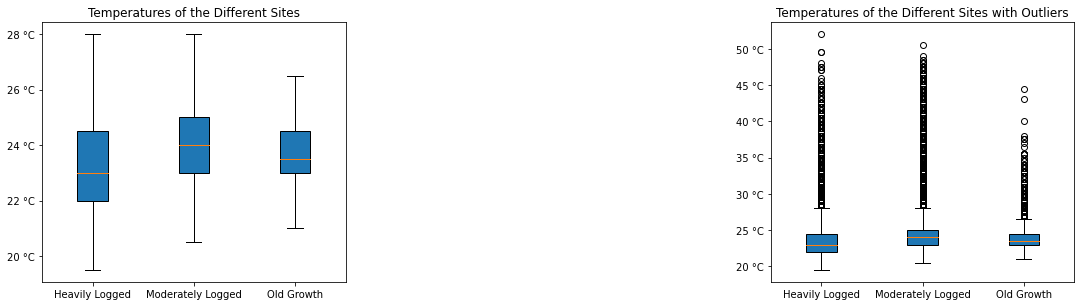

In [3]:
# Import logging data
x = pd.read_csv("/Users/samwinkworth/Downloads/FP Data/Logging/data/loggingLSD.csv") 
#df = pd.read_csv('https://git.cardiff.ac.uk/c1841779/interactive-data-science-to-help-tackle-climate-change/-/raw/master/data/loggingLSD.csv')

# Rename column for ease of use
x = x.rename(columns={"Forest.floor.temperature..degC.": "Temp"})
x = x.rename(columns={"Time.elapsed..s.": "Time_elapsed"})

# Create data frames for each type of logging site
Heavily_logged = x.loc[x['Site'] == 'Heavily logged']
Moderately_logged = x.loc[x['Site'] == 'Moderately logged']
Old_growth = x.loc[x['Site'] == 'Old growth']

# Create mean variables for each site
H_mean = Heavily_logged.groupby(['Time_elapsed']).mean()
M_mean = Moderately_logged.groupby(['Time_elapsed']).mean()
O_mean = Old_growth.groupby(['Time_elapsed']).mean()

# List of data to plot
data = [Heavily_logged['Temp'], Moderately_logged['Temp'], Old_growth['Temp']]

#Create figure and define dimensions, labels, and titles
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)

# Create box plot without outliers
ax1 = fig.add_subplot(231)
labels = ["Heavily Logged", "Moderately Logged", "Old Growth"]
ax1.set_title('Temperatures of the Different Sites')
ax1.boxplot(data, showfliers=False,patch_artist=True, labels=labels)
ax1.yaxis.set_major_formatter(EngFormatter(unit=u"°C"))

#Create box plot showing outliers
ax8 = fig.add_subplot(233)
ax8.set_title('Temperatures of the Different Sites with Outliers')
ax8.boxplot(data, showfliers=True,patch_artist=True, labels=labels)
ax8.yaxis.set_major_formatter(EngFormatter(unit=u"°C"))

ticks = [1,2,3]
plt.show()

<html>

<body>
    <p>The line graph, see below, shows the mean temperature of each type of site over time. This graph gives further evidence to show how logged sites experience more temperature variation.</p>
</body>
    
</html>

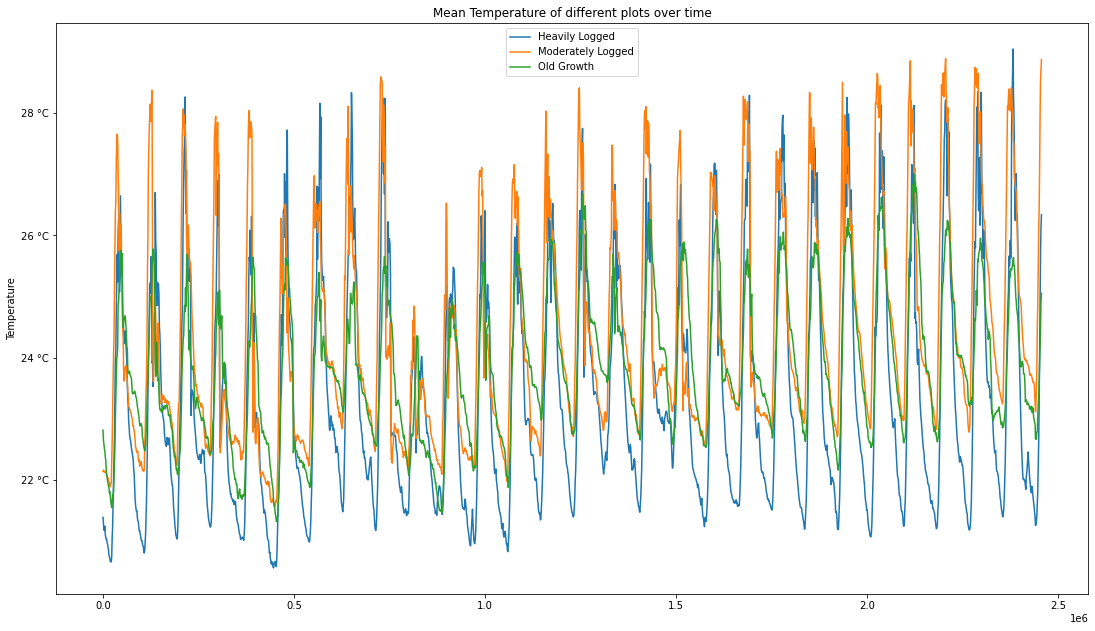

In [4]:
#Create line graph of mean temperatures showing each type of site    
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax1.set_ylabel('Temperature')
ax1.set_title('Mean Temperature of different plots over time')
ax1.yaxis.set_major_formatter(EngFormatter(unit=u"°C"))

# Loop to add means from all 3 data sets
for frame in [H_mean, M_mean, O_mean]:
    frame.reset_index(level=0)
    plt.plot(frame['Temp'])

plt.legend(('Heavily Logged', 'Moderately Logged', 'Old Growth'),
           loc='upper center')
plt.show()

<html>
<head>
  <title></title>
</head>
<body>

<h2>Animal Movement Tracking</h2>
<p>Animal GPS Collar data, supplied by the Danau Girang Field Centre, is visualised below. The map below shows either the latest animal locations or their average locations. These options can be toggled using the drop down menu supplied.</p>

</body>
</html>

In [5]:
## Animal Tracking Visualisations
# Visualisations to assist security forces in the fight against poaching

# Import animal tracking CSV created from Animal Tracking Prep 
df = pd.read_csv('/Users/samwinkworth/final-project/data/animal_tracking.csv')  

# Create list of all animal names in the CSV file
animalNames = df['Name'].unique().tolist()

# Create list to store all animal dataframes
animalDf=[]

# Loop to create dataframe for each animal's tracking data and append to list 
for name in animalNames:
    exec(f"{name}=df.loc[df['Name'] == name]")
    exec(f"animalDf.append({name})")

# The data is sorted in ascending date order in the Excel sheet
# Take the last row from each dataframe and append to new dataframe
animalMapping = pd.concat([i.tail(1) for i in animalDf], join="inner", keys=[a for a in animalNames])
animalMapping = animalMapping.droplevel(1)
animalMapping['Name'] = animalMapping.index

# Calculate each animals mean location and add to animalMapping dataframe
animalMapping['averageLat'] = [i['Lat'].mean() for i in animalDf]
animalMapping['averageLon'] = [i['Lon'].mean() for i in animalDf]

In [6]:
def tracking(Location):
    
 #   loc = animalMapping[['Lat', 'Lon']]
 #   locationList = loc.values.tolist()
    
    # Create map
    map = folium.Map(location=[5, 118.3], zoom_start=8)
    
    # Use Google Satellite Hybrid basemap
    basemaps['Google Satellite Hybrid'].add_to(map) 
    
    #GPS to allow users to easily locate themselves relative to visualisation.
    plugins.LocateControl().add_to(map)

    #Add measure tool 
    plugins.MeasureControl(position='topleft', primary_length_unit='meters', secondary_length_unit='miles', primary_area_unit='sqmeters', secondary_area_unit='acres').add_to(map)

    # Show latest location or average location of each animal
    if Location == 'Latest Location':
        loc = animalMapping[['Lat', 'Lon']]
    elif Location == 'Average Location':
        loc = animalMapping[['averageLat', 'averageLon']]
    else:
        raise ValueError('An incorrect input has been entered.')
    

    
    marker_cluster = folium.plugins.MarkerCluster().add_to(map)
    locationList = loc.values.tolist()
    for point in range(0, len(locationList)):
        html=f"""
        <h2>{animalMapping['Type'][point]} {animalMapping['Name'][point]}</h2>
        <p><table>
            <tr>
                <td>{Location}:</td>
                <td>{locationList[point]}</td> 
            </tr>
            <tr>
                <td>Age/Sex:</td>
                <td>{animalMapping['Age'][point]}/{animalMapping['Sex'][point]}</td> 
            </tr>
            <tr>
                <td>Capture Location:</td>
                <td>{animalMapping['Capture_Loc'][point]}</td> 
            </tr>
            <tr>
                <td>Release Location/Date:</td>
                <td>{animalMapping['Release_Loc'][point]}/{animalMapping['Release_Date'][point]}</td> 
            </tr>
            </table></p>
        <p>Further studies found <a href="https://sites.google.com/view/forestobservatory/home">Forest Observatory</a></p>
        """
        iframe = folium.IFrame(html=html, width=270, height=200)
        popup = folium.Popup(iframe, max_width=2650)
        folium.Marker(locationList[point], 
                      popup=popup,
                      icon = folium.DivIcon(html=f"""<img src="https://cdn0.iconfinder.com/data/icons/social-flat-rounded-rects/512/evernote-1024.png" width="37" height="37">""")
                                   ).add_to(marker_cluster)
        
    return map


interact(tracking, Location=['Latest Location', 'Average Location']);

interactive(children=(Dropdown(description='Location', options=('Latest Location', 'Average Location'), value=…

<html>
<head>
  <title></title>
</head>
<body>

    <h3>Elephant Tracking Time Series</h3>
    <p>The map below shows each elephants movements over time and their respective heat map.</p>
    <p>Multiple elephant movements can be visualised at once using the same time scale. Use the box below to select which animals' movements are shown. Press shift and/or ctrl (on windows) or command (on mac) and use mouse clicks or arrow keys to select desired animals.</p>
    
</body>
</html>

In [7]:
def timeStampedGeoJson(animalName, Visualisation):
    
    animalDict = dict(zip(animalNames, animalDf))

    if Visualisation == 'Time Series Animal Tracking':

        map = folium.Map(location=[5, 118.3], zoom_start=8)
        
        # Use Google Satellite Hybrid basemap
        basemaps['Google Satellite Hybrid'].add_to(map) 

        #GPS to allow users to easily locate themselves relative to visualisation.
        plugins.LocateControl().add_to(map)

        #Add measure tool 
        plugins.MeasureControl(position='topleft', primary_length_unit='meters', secondary_length_unit='miles', primary_area_unit='sqmeters', secondary_area_unit='acres').add_to(map)

        # Create list to hold features to add to map
        feature = []

        # Loop to add each animal's tracking feature to list
        for i in animalName:
            a = animalDict.get(i)
            r = lambda: random.randint(0,255)
            name = a.Name.iloc[0]
            animal = a.Type.iloc[0]
            feature.append(
                {
                    "type": "Feature",
                    "geometry": {
                        "type": "LineString",
                        "coordinates": a[['Lon', 'Lat']].values.tolist(),
                    },
                    "properties": {
                        "times": a['GMT Date ISO'].values.tolist(),
                        "style": {
                            "color": '#%02X%02X%02X' % (r(),r(),r()),
                            "weight": 2,
                        },
                        "popup": str(animal) + " : " + str(name),
                        'icon': 'marker',
                        'iconstyle': {
                            'iconSize': [20, 20],
                            'iconUrl':
                            'https://cdn0.iconfinder.com/data/icons/social-flat-rounded-rects/512/evernote-1024.png'
                        }
                    },
                }
            )


        plugins.TimestampedGeoJson(
            {
                "type": "FeatureCollection",
                "features": feature, 
            },
            period="P1D",
            add_last_point=True,
        ).add_to(map)
        
        # HTML template for showing rainy and wet season in Sabah
        season_template = """
        {% macro html(this, kwargs) %}

        <html lang="en">
        <head>
          <meta charset="utf-8">
        </head>
        <body>

        <div id='season_legend' class='season_legend' 
            style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
             border-radius:6px; padding: 5px; font-size:14px; right: 20px; top: 10px;'>

        <div class='legend-title'>Sabah Climate</div>
        <div class='legend-scale'>
          <ul class='legend-labels'>
            <li><span style='background:blue;opacity:0.7;'></span>Rainy Season: ~ Nov - Mar</li>
            <li><span style='background:orange;opacity:0.7;'></span>Dry Season: ~ Apr - Oct</li>
          </ul>
        </div>
        </div>

        </body>
        </html>

        <style type='text/css'>
          .season_legend .legend-title {
            text-align: left;
            margin-bottom: 5px;
            font-weight: bold;
            font-size: 90%;
            }
          .season_legend .legend-scale ul {
            margin: 0;
            margin-bottom: 5px;
            padding: 0;
            float: left;
            list-style: none;
            }
          .season_legend .legend-scale ul li {
            font-size: 80%;
            list-style: none;
            margin-left: 0;
            line-height: 18px;
            margin-bottom: 2px;
            }
          .season_legend ul.legend-labels li span {
            display: block;
            float: left;
            height: 16px;
            width: 20px;
            margin-right: 5px;
            margin-left: 0;
            border: 1px solid #999;
            }
          .season_legend .legend-source {
            font-size: 80%;
            color: #777;
            clear: both;
            }
          .season_legend a {
            color: #777;
            }
        </style>
        {% endmacro %}"""

        macro = MacroElement()
        macro._template = Template(season_template)

        map.get_root().add_child(macro)

        return map

    elif Visualisation == 'Heat Map':
        
        i = animalName[0]
        a = animalDict.get(i)
        r = lambda: random.randint(0,255)

        aLoc = [a['Lat'].mean(), a['Lon'].mean()]
        
        map = folium.Map(location=aLoc, zoom_start=9)
        
        # Use Google Satellite Hybrid basemap
        basemaps['Google Satellite Hybrid'].add_to(map) 

        #GPS to allow users to easily locate themselves relative to visualisation.
        plugins.LocateControl().add_to(map)

        #Add measure tool 
        plugins.MeasureControl(position='topleft', primary_length_unit='meters', secondary_length_unit='miles', primary_area_unit='sqmeters', secondary_area_unit='acres').add_to(map)


        location = a[['Lat', 'Lon']]
        locationList = location.values.tolist()
        folium.plugins.HeatMap(locationList).add_to(map)
        
        return map
    
    else:
        raise ValueError('An incorrect input has been entered.')
    


animal_select = widgets.SelectMultiple(
    options=animalNames,
    value=['Kuma'],
    rows=5,
    description='Animals',
    disabled=False
)
vis_type = widgets.RadioButtons(
    options=['Time Series Animal Tracking', 'Heat Map'],
    description='Type of Visualisation',
    disabled=False
)
widgets.interact(timeStampedGeoJson, animalName=animal_select, Visualisation=vis_type);

interactive(children=(SelectMultiple(description='Animals', index=(0,), options=('Kuma', 'Jasmin', 'Putut', 'B…

<html>
<head>
  <title></title>
</head>
<body>

<h2>Reference List</h2>
<p>Blonder, B., Both, S., Coomes, D.A., Elias, D., Jucker, T., Kvasnica, J., Majalap, N., Malhi, Y.S., Milodowski, D., Riutta, T. and Svátek, M. (2018). Extreme and Highly Heterogeneous Microclimates in Selectively Logged Tropical Forests. Frontiers in Forests and Global Change, 1.</p>

<p>Friedl, M. and Sulla-Menashe, D. (2019). MCD12Q1 MODIS/Terra+Aqua Land Cover Type Yearly L3 Global 500m SIN Grid V006. [online] Available at: https://lpdaac.usgs.gov/products/mcd12q1v006/ [Accessed 19 Apr. 2022].</p>

<p>Hansen, M.C., Potapov, P.V., Moore, R., Hancher, M., Turubanova, S.A., Tyukavina, A., Thau, D., Stehman, S.V., Goetz, S.J., Loveland, T.R., Kommareddy, A., Egorov, A., Chini, L., Justice, C.O. and Townshend, J.R.G. (2013). High-Resolution Global Maps of 21st-Century Forest Cover Change. Science 342 (15 November): 850–53. [online] Available at: http://earthenginepartners.appspot.com/science-2013-global-forest.</p>

<p>Wan, Z., Hook, S. and Hulley, G. (2021). MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061. [online] Available at: https://lpdaac.usgs.gov/products/mod11a1v061/.</p>

</body>
</html>